<a href="https://colab.research.google.com/github/Keerthana-ak-commits/Forest-fire-detection-using-deep-learning/blob/main/Wildfire_prediction_using_DL(Resnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00


In [ ]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-wildfire-dataset


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('GPU is Available!')
else:
  print('GPU is Unavailable!')

GPU is Available!


In [ ]:
train_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/train'
val_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/val'
test_dir = '/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version/test'

In [ ]:
classes = os.listdir(train_dir)
num_classes = len(classes)

# Display the class names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 2
Classes: ['nofire', 'fire']


In [ ]:
img_width, img_height = 150, 150
batch_size = 32 # there will be 32 images in a batch!

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.


In [ ]:

# map the indices
class_mapping = train_generator.class_indices
# print(class_mapping)
# Extract the class names
class_names = list(class_mapping.keys())
print("Class Names:", class_names)

Class Names: ['fire', 'nofire']


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Image size for ResNet50
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Compute class weights for imbalance
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))

# Load ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Make all layers trainable
base_model.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=16,
    class_weight=class_weights
)

# Evaluate
model.evaluate(test_generator)


Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 410 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


33/59 ━━━━━━━━━━━━━━━━━━━━ 3:13 7s/step - accuracy: 0.7014 - loss: 0.5858

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


59/59 ━━━━━━━━━━━━━━━━━━━━ 608s 9s/step - accuracy: 0.7490 - loss: 0.5185 - val_accuracy: 0.6119 - val_loss: 2.6001
Epoch 2/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 498s 8s/step - accuracy: 0.9623 - loss: 0.1463 - val_accuracy: 0.3881 - val_loss: 2.0069
Epoch 3/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 546s 9s/step - accuracy: 0.9554 - loss: 0.1228 - val_accuracy: 0.3881 - val_loss: 1.0057
Epoch 4/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 510s 9s/step - accuracy: 0.9630 - loss: 0.1058 - val_accuracy: 0.3881 - val_loss: 1.2345
Epoch 5/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 575s 10s/step - accuracy: 0.9754 - loss: 0.0716 - val_accuracy: 0.6070 - val_loss: 0.7306
Epoch 6/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 515s 9s/step - accuracy: 0.9595 - loss: 0.1036 - val_accuracy: 0.4080 - val_loss: 1.4744
Epoch 7/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 524s 9s/step - accuracy: 0.9840 - loss: 0.0507 - val_accuracy: 0.5970 - val_loss: 0.7008
Epoch 8/16
59/59 ━━━━━━━━━━━━━━━━━━━━ 532s 9s/step - accuracy: 0.9883 - loss: 0.0353 - val_accuracy: 0.6244 - val_loss: 0

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 9s/step - accuracy: 0.8453 - loss: 0.4963


[0.3612418472766876, 0.8878048658370972]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs.cpu()))
        all_preds.extend(preds.numpy().flatten())
        all_labels.extend(labels.numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=train_data.classes))


AttributeError: 'Functional' object has no attribute 'eval'

In [ ]:
model.save('model.h5')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your ResNet50-based model
model = load_model('model.h5')  # Ensure this is your saved ResNet50 model

# Define class names (update as per your folder structure)
class_names = ['fire', 'nofire']

# Predict function
def predict_fire(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # ResNet50 expects 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale like during training

    # Prediction
    prediction = model.predict(img_array)

    # Interpret result
    if prediction[0][0] > 0.5:
        predicted_class = class_names[1]  # 'Fire'
        confidence = prediction[0][0]
    else:
        predicted_class = class_names[0]  # 'Not Fire'
        confidence = 1 - prediction[0][0]

    # Display
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


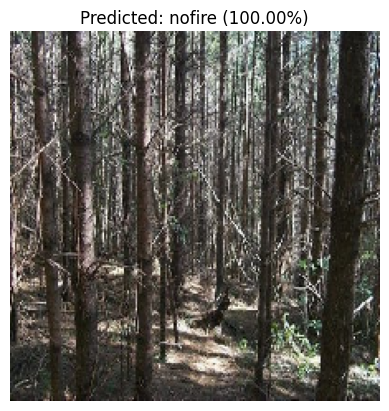

In [ ]:
predict_fire('/no fire.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')